In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [4]:
enteroOrg = pd.read_csv("../data/EnteroEpitopes.csv", index_col=0)

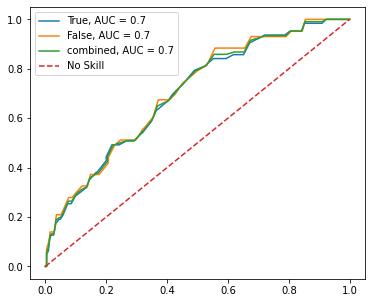

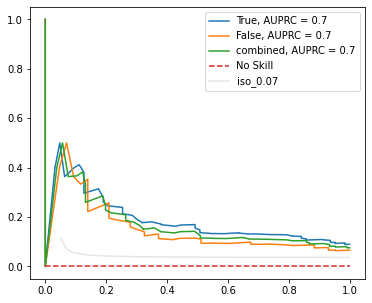

In [5]:
matplotlib.rcParams['figure.figsize'] = [6, 5]

fig_roc, ax_roc = plt.subplots()
fig_pr, ax_pr = plt.subplots()

for function in [True, False, "combined"]:
    entero = enteroOrg
    if function != "combined":
        entero = enteroOrg[enteroOrg["has_stop"]==function].copy()
        
    entero["reactive"] = entero["reactiveSamples"] > 0
    fpr, tpr, _ = roc_curve(entero["reactive"], entero["proba"])
    auc_score = round(metrics.roc_auc_score(entero["reactive"], entero["proba"]) ,2)       
    auprc_score = round(metrics.average_precision_score(entero["reactive"], entero["proba"]) ,2)       
    precision, recall, _ = precision_recall_curve(entero["reactive"], entero["proba"])
    ax_roc.plot(fpr, tpr, label=str(function) + ", AUC = " + str(auc_score))
    ax_pr.plot(recall, precision, label=str(function) + ", AUPRC = " + str(auc_score))

ax_roc.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
ax_pr.plot([0, 1], [0, 0], linestyle='--', label='No Skill')
f_score = entero["reactive"].value_counts()[1]/len(entero["reactive"])
x = np.linspace(0.01, 1)
yf = f_score * x / (2 * x - f_score)
ax_pr.plot(x[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2, label = "iso_"+str(round(f_score,2)))
plt.ylim([-0.05, 1.05])
ax_roc.legend()
ax_pr.legend()
plt.show()

In [6]:
species7 = {}
with open("../data/EV_ref_7species.faa", "r") as f:
    for line in f.readlines():
        if line.startswith(">"):
            species = line.rstrip()[1:]
        else:
            species7[species] = line.rstrip()
            
bepi_score_full = pd.read_csv("../data/raw_output_Bepi3_full.csv", sep=",")
bepi_score_full = bepi_score_full.rename(columns={"BepiPred-3.0 score": "score", "BepiPred-3.0 rolling mean score": "score_rolling_mean"})
bepi_score_full.Accession = bepi_score_full.Accession.str[:-2]

def getBepi3ScoreFull(AAseq, taxon_id):
    position = species7[taxon_id].find(AAseq)
    score = bepi_score_full[bepi_score_full.Accession == taxon_id].iloc[position:position+15,2].mean()
    return(score)

bepi_score = pd.read_csv("../data/raw_output_Bepi3.csv", sep=",")
bepi_score = bepi_score.rename(columns={"BepiPred-3.0 score": "score", "BepiPred-3.0 rolling mean score": "score_rolling_mean"})

def getBepi3Score(AAseq):
    score = bepi_score[bepi_score.Accession == AAseq].score.mean()
    return(score)

In [7]:
# pull BepiPred3 Probabilities from files ../data/raw_output_Bepi3_full and ../data/raw_output_Bepi3
enteroOrg["Bepi_proba_full"] = [getBepi3ScoreFull(row.pep_aa,row.taxon_id) for index, row in enteroOrg.iterrows()]
enteroOrg["Bepi_proba_15"] = [getBepi3Score(row.pep_aa) for index, row in enteroOrg.iterrows()]

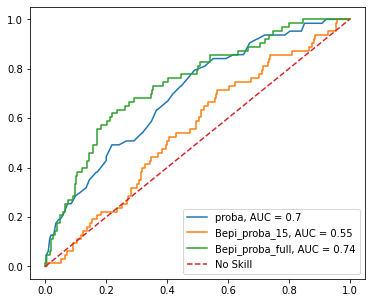

In [8]:
matplotlib.rcParams['figure.figsize'] = [6, 5]

fig_roc, ax_roc = plt.subplots()

for proba in ["proba", "Bepi_proba_15", "Bepi_proba_full"]:
    entero = enteroOrg[enteroOrg["has_stop"]==True].copy()
    entero["reactive"] = entero["reactiveSamples"] > 0
    fpr, tpr, _ = roc_curve(entero["reactive"], entero[proba])
    auc_score = round(metrics.roc_auc_score(entero["reactive"], entero[proba]) ,2)       
    auprc_score = round(metrics.average_precision_score(entero["reactive"], entero[proba]) ,2)       
    precision, recall, _ = precision_recall_curve(entero["reactive"], entero[proba])
    ax_roc.plot(fpr, tpr, label=proba + ", AUC = " + str(auc_score))
    sourcedata = pd.DataFrame()
    sourcedata["FPR"] = fpr
    sourcedata["TPR"] = tpr
    #sourcedata.to_csv("../data/SourceData/Fig2E_"+proba+".csv")

ax_roc.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
f_score = entero["reactive"].value_counts()[1]/len(entero["reactive"])
x = np.linspace(0.01, 1)
yf = f_score * x / (2 * x - f_score)
ax_pr.plot(x[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2, label = "iso_"+str(round(f_score,2)))
plt.ylim([-0.05, 1.05])
ax_roc.legend()
plt.show()